## Steps
1. read data
2. time differential
3. PSD (using welch)
4. extract features
5. match labels (target)
6. add patient id

In [1]:
import os
import glob
import re
import numpy as np
import numpy.fft as fft
import mne
import matplotlib.pyplot as plt
from scipy import stats, signal
from numpy import save, load
import pandas as pd
import pywt

In [2]:
# subject_id = 23
# base_path = "physionet.org/files/chbmit/1.0.0/"
# edf_file_names = sorted(glob.glob(os.path.join(base_path, "chb{:02d}/*.edf".format(subject_id))))
# summary_file = os.path.join(base_path, "chb{:02d}/chb{:02d}-summary.txt".format(subject_id, subject_id))


# summary_content = open(summary_file,'r').read()

In [3]:
def extract_data_and_labels(edf_filename, summary_text):
    folder, basename = os.path.split(edf_filename)
    
    edf = mne.io.read_raw_edf(edf_filename,stim_channel=None)
    # X = edf.get_data().astype(np.float32) * 1e6 # to mV
    X= shuffle_channels(edf).astype(np.float32)
    print (X.shape)
    y = np.zeros(X.shape[1], dtype=np.int64)
    i_text_start = summary_text.index(basename)

    if 'File Name' in summary_text[i_text_start:]:
        i_text_stop = summary_text.index('File Name', i_text_start)
    else:
        i_text_stop = len(summary_text)
    assert i_text_stop > i_text_start

    file_text = summary_text[i_text_start:i_text_stop]
    # print(file_text)
    num_seizures = int(re.search(r"Number of Seizures in File: ([0-9]*)", file_text).group(1))
    
    # if 'Seizure ' in file_text:
    if num_seizures>0:
        for sez in range(1, num_seizures+1):
            # print(re.search(rf"Seizure[\s]*[{str(sez)}]* Start Time:[\s]* ([0-9]*) seconds", file_text))
            start_sec = int(re.search(rf"Seizure[\s]*[{str(sez)}]* Start Time:[\s]* ([0-9]*) seconds", file_text).group(1))
            print(start_sec)
            end_sec = int(re.search(rf"Seizure[\s]*[{str(sez)}]* End Time:[\s]* ([0-9]*) seconds", file_text).group(1))
            print(end_sec)
            i_seizure_start = int(round(start_sec * edf.info['sfreq']))
            i_seizure_stop = int(round((end_sec + 1) * edf.info['sfreq']))
            y[i_seizure_start:i_seizure_stop] = 1
    assert X.shape[1] == len(y)
    return X,y

In [4]:
channel_order= {'FP1-F7':0, 'F7-T7':1, 'T7-P7':2, 'P7-O1':3, 'FP1-F3':4, 'F3-C3':5, 'C3-P3':6, 'P3-O1':7, 'FP2-F4':8, 'F4-C4':9, 'C4-P4':10, 'P4-O2':11, 'FP2-F8':12, 'F8-T8':13, 'T8-P8-0':14, 'P8-O2':15, 'FZ-CZ':16, 'CZ-PZ':17, 'P7-T7':18, 'T7-FT9':19, 'FT9-FT10':20, 'FT10-T8':21 ,'T8-P8-1':22 }
def shuffle_channels(data):
    channels=data.ch_names
    d=data.get_data().astype(np.float32) * 1e6 
    res= [0]*23
    # res=np.zeros_like(res)
    i=0
    for ch in channels:
        if channel_order.get(ch)!=None:
            idx=channel_order[ch]
            res[idx]=np.array(d[i])
        i+=1
    r=np.zeros_like(res)
    for i in range(0,23):
        r[i]=res[i]
    return r

In [5]:
# X_23 = []
# y_23 = []
# for edf_file_name in edf_file_names:
#     X, y = extract_data_and_labels(edf_file_name, summary_content)
#     X_23.append(X)
#     y_23.append(y)

In [6]:
# len(X_23)

In [7]:
def time_differential(x_series):
    a=[]
    for ch in x_series:
        c=np.zeros_like(ch)
        for i in range (1,len(ch)):
            c[i]=ch[i]-ch[i-1]
        a.append(c)
    return np.array(a)

    

In [8]:
label_dict ={0: 'interictal', 1: 'ictal', 2: 'preictal', 3: 'dismiss'}

In [9]:
def label_series(labels, preictalmins):
    interictal=60*60*256
    preictal=preictalmins*60*256
    # interictal=4
    # preictal=2
    seizure_starts=[]
    seizure_ends=[]
    if labels[0]==1:
        seizure_starts.append(0)
    for i in range(1,len(labels)):
        if labels[i]==1 and labels[i-1]==0:
            seizure_starts.append(i)
        if labels[i]==0 and labels[i-1]==1:
            seizure_ends.append(i)
    # print(seizure_starts)
    # print(seizure_ends)
    for point in seizure_starts:
        # print(point)
        for j in range(max(0, point-preictal), point):
            if labels[j]!=1:
                labels[j]=2
        for k in range(max(0, point-interictal), point):
            if labels[k]==0:
                labels[k]=3
    for point in seizure_ends:
        for j in range(point, min(interictal+ point, len(labels))):
            if labels[j]==0:
                labels[j]=3
    return labels
        

           



In [10]:
def check_channel_match(channels):
    i=0
    for ch in channels:
        if channel_order.get(ch)==None or channel_order[ch]!=i:
            return False
        i+=1
    return True


In [11]:
def extract_frequency(freqs, psd, start, end):
    start_idx=np.where(np.isclose(freqs, start))[0][0]
    if end==-1:
        end_idx=-1
    else:
        end_idx=np.where(np.isclose(freqs, end))[0][0]
    return psd[start_idx:end_idx].sum()


In [12]:
def set_frequency(freqs, psd, start, end, value):
    start_idx=np.where(np.isclose(freqs, start))[0][0]
    if end==-1:
        end_idx=-1
    else:
        end_idx=np.where(np.isclose(freqs, end))[0][0]    
    psd[start_idx:end_idx]=value

In [13]:
from scipy.stats.stats import pearsonr

def order_correlation(data, target):
    df=pd.DataFrame(data=data, columns=generate_column_names())
    df['target']=target
    df=df.dropna()
    df=df[(df['target']!=3)]
    coefs=np.zeros(len(df.columns)-1)
    p_vals=np.zeros(len(df.columns)-1)
    for i in range(0,len(df.columns)-1):
        (coefs[i], p_vals[i])=pearsonr(df[df.columns[i]], df['target'])
    corr_df=pd.DataFrame(data={'corr01':coefs,'p01': p_vals})
    corr_df['feature']=df.columns[:-1]
    corr_df=corr_df.sort_values('corr01', ascending=False)
    return corr_df['feature']

In [14]:
def generate_column_names():
    channel_order= {'FP1-F7':0, 'F7-T7':1, 'T7-P7':2, 'P7-O1':3, 'FP1-F3':4, 'F3-C3':5, 'C3-P3':6, 'P3-O1':7, 'FP2-F4':8, 'F4-C4':9, 'C4-P4':10, 'P4-O2':11, 'FP2-F8':12, 'F8-T8':13, 'T8-P8-0':14, 'P8-O2':15, 'FZ-CZ':16, 'CZ-PZ':17, 'P7-T7':18, 'T7-FT9':19, 'FT9-FT10':20, 'FT10-T8':21 ,'T8-P8-1':22 }
    col_names=[]
    for ch in channel_order:
        # print(ch)
        for i in range(0,9):
            col_names.append(str(ch)+'-'+str(i))
    col_names.append('rms')
    col_names.append('sum')
    # col_names.append('patient')
    return col_names

In [26]:
def get_crossings(decomp):
    crossings=0
    for i in range(1,len(decomp)):
        if decomp[i]*decomp[i-1]:
            crossings+=1
    return crossings


In [15]:
# patient_no=1#################

# for patient_no in range(1,6):
#     subject_id = patient_no
#     base_path = "physionet.org/files/chbmit/1.0.0/"
#     edf_file_names = sorted(glob.glob(os.path.join(base_path, "chb{:02d}/*.edf".format(subject_id))))
#     summary_file = os.path.join(base_path, "chb{:02d}/chb{:02d}-summary.txt".format(subject_id, subject_id))


#     summary_content = open(summary_file,'r').read()

#     X_all = []
#     y_all = []
#     for edf_file_name in edf_file_names:
#         X, y = extract_data_and_labels(edf_file_name, summary_content)
#         X_all.append(X)
#         y_all.append(y)

#     window_size=int(256*20)
#     for filno in range(0,len(X_all)):###################
#         recording=X_all[filno]####################
#         discarded=0
#         wins=recording.shape[1]//window_size
#         print('file: {} , shape: {} '.format(filno,recording.shape))
#         y=label_series(y_all[filno], 10)#############################33333
#         datapoints_in=[] #for each file
#         targets=[]
#         i=0
#         while i+window_size<recording.shape[1]:
#             # n_channels=recording.shape[0]
#             n_channels=23
#             # features=np.zeros(n_channels*9+1)
#             features=np.zeros(3)
#             features[2]=patient_no
#             recording.shape
#             window=time_differential(recording[:,int(i):int(i+window_size)])
#             # window=recording[:,int(i):int(i+window_size)]
#             freqs, psd = signal.periodogram(window, fs=256)
#             features[0]=psd.sum()
#             features[1]=np.sqrt(np.mean(psd**2))
#             target_range=np.array(y[int(i):int(i+window_size)])

#             if np.all(target_range == target_range[0]):
#                 target=target_range[0]
#                 targets.append(target)
#                 datapoints_in.append(features)
#             else:
#                 discarded+=1               
#             i+=(window_size/2)
#         # dp=np.array(datapoints_in)
#         # D:\salma\UNI\Sem8\WS\unnormalized
#         save(os.path.join('sum_only','data_chb{:02d}/features_{}_{:02d}'.format(patient_no, patient_no, filno)), datapoints_in)
#         save(os.path.join('sum_only','data_chb{:02d}/targets_{}_{:02d}'.format(patient_no,patient_no, filno)) , targets)
#         print('total number of windows: {} , number of windows discarded: {} '.format(i/(window_size/2), discarded))
        



- Channel 1: FP1-F7  ----0
- Channel 2: F7-T7   ----1
- Channel 3: T7-P7   ----2
- Channel 4: P7-O1   ----3
- Channel 5: -
- Channel 6: FP1-F3  ----4
- Channel 7: F3-C3   ----5
- Channel 8: C3-P3   ----6
- Channel 9: P3-O1   ----7
- Channel 10: -
- Channel 11: FZ-CZ   ----16
- Channel 12: CZ-PZ   ----17
- Channel 13: -
- Channel 14: FP2-F4   ----8
- Channel 15: F4-C4   ----9
- Channel 16: C4-P4  ----10
- Channel 17: P4-O2   ----11
- Channel 18: -
- Channel 19: FP2-F8   ----12
- Channel 20: F8-T8   ----13
- Channel 21: T8-P8   ----14
- Channel 22: P8-O2   ----15
- Channel 23: -
- Channel 24: P7-T7   ----18
- Channel 25: T7-FT9   ----19
- Channel 26: FT9-FT10   ----20
- Channel 27: FT10-T8   ----21
- Channel 28: T8-P8   ----22


## HAAR 10 sec window

['physionet.org/files/chbmit/1.0.0/chb01/chb01_03.edf']
Extracting EDF parameters from d:\salma\UNI\Sem8\WS\physionet.org\files\chbmit\1.0.0\chb01\chb01_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
<ipython-input-3-0a23d589a01a>:4: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  edf = mne.io.read_raw_edf(edf_filename,stim_channel=None)
<ipython-input-3-0a23d589a01a>:4: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  edf = mne.io.read_raw_edf(edf_filename,stim_channel=None)
(23, 1042176)
2996
3036
(22, 2560)
(640,)


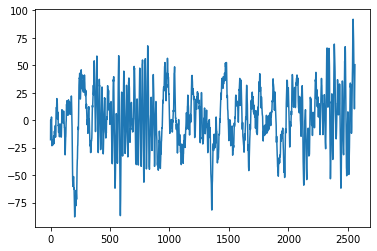

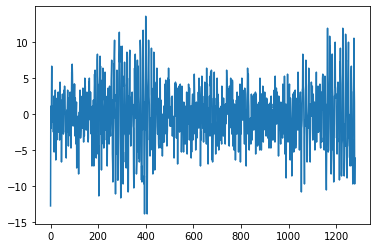

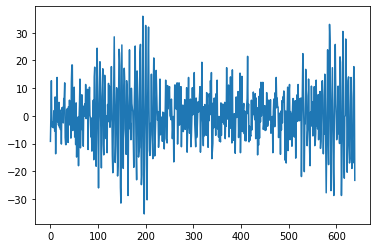

629
1182


In [28]:
# data=
subject_id = 1
filenum=3
base_path = "physionet.org/files/chbmit/1.0.0/"
edf_file_name = sorted(glob.glob(os.path.join(base_path, "chb{:02d}/chb{:02d}_{:02d}.edf".format(subject_id,subject_id, filenum))))
summary_file = os.path.join(base_path, "chb{:02d}/chb{:02d}-summary.txt".format(subject_id, subject_id))

summary_content = open(summary_file,'r').read()
print(edf_file_name)
X, y = extract_data_and_labels(edf_file_name[0], summary_content)

window_size=int(256*10)
window=X[:22,0:window_size]
coeffs = pywt.wavedec(window[0], 'haar', level=2)
plt.figure()
plt.plot( np.arange(0,2560),window[0])
plt.show()
plt.figure()
plt.plot(np.arange(0,1280),coeffs[2])
plt.show()
plt.figure()
plt.plot(np.arange(0,640),coeffs[1])
plt.show()

print(get_crossings(coeffs[1]))
print(get_crossings(coeffs[2]))




In [31]:
patient_no=1#################

for patient_no in range(1,25):
    subject_id = patient_no
    base_path = "physionet.org/files/chbmit/1.0.0/"
    edf_file_names = sorted(glob.glob(os.path.join(base_path, "chb{:02d}/*.edf".format(subject_id))))
    summary_file = os.path.join(base_path, "chb{:02d}/chb{:02d}-summary.txt".format(subject_id, subject_id))


    summary_content = open(summary_file,'r').read()

    X_all = []
    y_all = []
    for edf_file_name in edf_file_names:
        X, y = extract_data_and_labels(edf_file_name, summary_content)
        X_all.append(X)
        y_all.append(y)

    window_size=int(256*20)
    for filno in range(0,len(X_all)):###################
        recording=X_all[filno]####################
        discarded=0
        wins=recording.shape[1]//window_size
        print('file: {} , shape: {} '.format(filno,recording.shape))
        y=label_series(y_all[filno], 10)#############################33333
        datapoints_in=[] #for each file
        targets=[]
        i=0
        while i+window_size<recording.shape[1]:
            # n_channels=recording.shape[0]
            n_channels=23
            features=np.zeros(22*2+1)
            features[-1]=patient_no
        
            window=recording[:22,int(i):int(i+window_size)]
       
            target_range=np.array(y[int(i):int(i+window_size)])
            for chi in range (0, n_channels-1):
                coeffs = pywt.wavedec(window[chi], 'haar', level=2)
            
                features[2*chi]=get_crossings(coeffs[1])
                features[2*chi+1]=get_crossings(coeffs[2])


            if np.all(target_range == target_range[0]):
                target=target_range[0]
                targets.append(target)
                datapoints_in.append(features)
            else:
                discarded+=1               
            i+=(window_size/2)
        # dp=np.array(datapoints_in)
        # D:\salma\UNI\Sem8\WS\unnormalized
        
        save(os.path.join('zero_crossings','data_chb{:02d}/features_{}_{:02d}'.format(patient_no, patient_no, filno)), datapoints_in)
        save(os.path.join('zero_crossings','data_chb{:02d}/targets_{}_{:02d}'.format(patient_no,patient_no, filno)) , targets)
        print('total number of windows: {} , number of windows discarded: {} '.format(i/(window_size/2), discarded))
        




_edf(edf_filename,stim_channel=None)
(23, 921600)
3367
3425
Extracting EDF parameters from d:\salma\UNI\Sem8\WS\physionet.org\files\chbmit\1.0.0\chb22\chb22_21.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
<ipython-input-3-0a23d589a01a>:4: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  edf = mne.io.read_raw_edf(edf_filename,stim_channel=None)
(23, 921600)
Extracting EDF parameters from d:\salma\UNI\Sem8\WS\physionet.org\files\chbmit\1.0.0\chb22\chb22_22.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
<ipython-input-3-0a23d589a01a>:4: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  edf = mne.io.read_raw_edf(edf_filename,stim_channel=None)
(23, 921600)
Extracting EDF parameters from d:\salma\UNI\Sem8\WS\physionet.org\files\chbmit\1.0.0\chb22\chb22

In [56]:
patient_no=1#################

for patient_no in range(1,6):
    subject_id = patient_no
    base_path = "physionet.org/files/chbmit/1.0.0/"
    edf_file_names = sorted(glob.glob(os.path.join(base_path, "chb{:02d}/*.edf".format(subject_id))))
    summary_file = os.path.join(base_path, "chb{:02d}/chb{:02d}-summary.txt".format(subject_id, subject_id))


    summary_content = open(summary_file,'r').read()

    X_all = []
    y_all = []
    for edf_file_name in edf_file_names:
        X, y = extract_data_and_labels(edf_file_name, summary_content)
        X_all.append(X)
        y_all.append(y)

    window_size=int(256*20)
    for filno in range(0,len(X_all)):###################
        recording=X_all[filno]####################
        discarded=0
        wins=recording.shape[1]//window_size
        print('file: {} , shape: {} '.format(filno,recording.shape))
        y=label_series(y_all[filno], 10)#############################33333
        datapoints_in=[] #for each file
        targets=[]
        i=0
        while i+window_size<recording.shape[1]:
            # n_channels=recording.shape[0]
            n_channels=23
            features=np.zeros(n_channels*9+2)
            # features[-1]=patient_no
            recording.shape
            window=time_differential(recording[:,int(i):int(i+window_size)])
            # window=recording[:,int(i):int(i+window_size)]
            freqs, psd = signal.periodogram(window, fs=256)
            features[-1]=psd.sum()
            features[-2]=np.sqrt(np.mean(psd**2))
            #removing electric noise
            # psd[:,57:64]=0
            # psd[:,117:124]=0
            target_range=np.array(y[int(i):int(i+window_size)])
            for chi in range (0, n_channels):
                set_frequency(freqs, psd[chi],57,64, 0)
                set_frequency(freqs, psd[chi],117,124, 0)
                # alpha=np.sum(psd[chi,8:14])
                alpha =extract_frequency(freqs, psd[chi],8,14)
                # beta=np.sum(psd[chi,13:31])
                beta = extract_frequency(freqs, psd[chi],13,31)
                # delta=np.sum(psd[chi,1:5])
                delta =extract_frequency(freqs, psd[chi],0.5,5)
                # theta=np.sum(psd[chi, 4:9])
                theta =extract_frequency(freqs, psd[chi],4,9)
                # gamma0=np.sum(psd[chi,30:48])
                gamma0=extract_frequency(freqs, psd[chi],30,48)
                # gamma1=np.sum(psd[chi,53:76])
                gamma1=extract_frequency(freqs, psd[chi],53,76)
                # gamma2=np.sum(psd[chi,75:98])
                gamma2=extract_frequency(freqs, psd[chi],75,98)
                # gamma3=np.sum(psd[chi,103:])
                gamma3=extract_frequency(freqs, psd[chi],103,-1)
                features[chi*9:(1+chi)*9-1]=[alpha,beta,delta,theta,gamma0,gamma1,gamma2,gamma3]
                # total_power=np.sum(features[chi*9:(1+chi)*9-1])
                total_power=np.sum(psd[chi])
                features[chi*9:(1+chi)*9-1] /= total_power
                features[(1+chi)*9-1]=total_power
            if np.all(target_range == target_range[0]):
                target=target_range[0]
                targets.append(target)
                datapoints_in.append(features)
            else:
                discarded+=1               
            i+=(window_size/2)
        # dp=np.array(datapoints_in)
        # D:\salma\UNI\Sem8\WS\unnormalized
        ft=order_correlation(datapoints_in, targets)
        newdf=pd.DataFrame(data=datapoints_in, columns=generate_column_names())
        newdf=newdf.reindex(columns=ft)
        newdf["patient"]=patient_no
        # mean_sum=np.mean(newdf['rms'][newdf['target']==0])
        
        
        datapoints_in=np.array(newdf)
        save(os.path.join('features_sorted','data_chb{:02d}/features_{}_{:02d}'.format(patient_no, patient_no, filno)), datapoints_in)
        save(os.path.join('features_sorted','data_chb{:02d}/targets_{}_{:02d}'.format(patient_no,patient_no, filno)) , targets)
        print('total number of windows: {} , number of windows discarded: {} '.format(i/(window_size/2), discarded))
        



Extracting EDF parameters from d:\salma\UNI\Sem8\WS\physionet.org\files\chbmit\1.0.0\chb05\chb05_20.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
<ipython-input-39-0a23d589a01a>:4: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  edf = mne.io.read_raw_edf(edf_filename,stim_channel=None)
(23, 921600)
Extracting EDF parameters from d:\salma\UNI\Sem8\WS\physionet.org\files\chbmit\1.0.0\chb05\chb05_21.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
<ipython-input-39-0a23d589a01a>:4: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  edf = mne.io.read_raw_edf(edf_filename,stim_channel=None)
(23, 921600)
Extracting EDF parameters from d:\salma\UNI\Sem8\WS\physionet.org\files\chbmit\1.0.0\chb05\chb05_22.edf...
EDF file detected
Setting channel info structure...
Creat

## features_notwelch
- 10 minutes preictal interval
- differentiation
- using plain vanilla psd

In [16]:
patient_no=1#################

for patient_no in range(13,20):
    subject_id = patient_no
    base_path = "physionet.org/files/chbmit/1.0.0/"
    edf_file_names = sorted(glob.glob(os.path.join(base_path, "chb{:02d}/*.edf".format(subject_id))))
    summary_file = os.path.join(base_path, "chb{:02d}/chb{:02d}-summary.txt".format(subject_id, subject_id))


    summary_content = open(summary_file,'r').read()

    X_all = []
    y_all = []
    for edf_file_name in edf_file_names:
        X, y = extract_data_and_labels(edf_file_name, summary_content)
        X_all.append(X)
        y_all.append(y)

    window_size=int(256*20)
    for filno in range(0,len(X_all)):###################
        recording=X_all[filno]####################
        discarded=0
        wins=recording.shape[1]//window_size
        print('file: {} , shape: {} '.format(filno,recording.shape))
        y=label_series(y_all[filno], 10)#############################33333
        datapoints_in=[] #for each file
        targets=[]
        i=0
        while i+window_size<recording.shape[1]:
            # n_channels=recording.shape[0]
            n_channels=23
            features=np.zeros(n_channels*9+1)
            features[-1]=patient_no
            recording.shape
            window=time_differential(recording[:,int(i):int(i+window_size)])
            # window=recording[:,int(i):int(i+window_size)]
            freqs, psd = signal.periodogram(window, fs=256)
            # features[-2]=psd.sum()
            # features[-3]=np.sqrt(np.mean(psd**2))
            #removing electric noise
            # psd[:,57:64]=0
            # psd[:,117:124]=0
            target_range=np.array(y[int(i):int(i+window_size)])
            for chi in range (0, n_channels):
                set_frequency(freqs, psd[chi],57,64, 0)
                set_frequency(freqs, psd[chi],117,124, 0)
                # alpha=np.sum(psd[chi,8:14])
                alpha =extract_frequency(freqs, psd[chi],8,14)
                # beta=np.sum(psd[chi,13:31])
                beta = extract_frequency(freqs, psd[chi],13,31)
                # delta=np.sum(psd[chi,1:5])
                delta =extract_frequency(freqs, psd[chi],0.5,5)
                # theta=np.sum(psd[chi, 4:9])
                theta =extract_frequency(freqs, psd[chi],4,9)
                # gamma0=np.sum(psd[chi,30:48])
                gamma0=extract_frequency(freqs, psd[chi],30,48)
                # gamma1=np.sum(psd[chi,53:76])
                gamma1=extract_frequency(freqs, psd[chi],53,76)
                # gamma2=np.sum(psd[chi,75:98])
                gamma2=extract_frequency(freqs, psd[chi],75,98)
                # gamma3=np.sum(psd[chi,103:])
                gamma3=extract_frequency(freqs, psd[chi],103,-1)
                features[chi*9:(1+chi)*9-1]=[alpha,beta,delta,theta,gamma0,gamma1,gamma2,gamma3]
                # total_power=np.sum(features[chi*9:(1+chi)*9-1])
                total_power=np.sum(psd[chi])
                features[chi*9:(1+chi)*9-1] /= total_power
                features[(1+chi)*9-1]=total_power
            if np.all(target_range == target_range[0]):
                target=target_range[0]
                targets.append(target)
                datapoints_in.append(features)
            else:
                discarded+=1               
            i+=(window_size/2)
        # dp=np.array(datapoints_in)
        # D:\salma\UNI\Sem8\WS\unnormalized
        
        save(os.path.join('features_notwelch','data_chb{:02d}/features_{}_{:02d}'.format(patient_no, patient_no, filno)), datapoints_in)
        save(os.path.join('features_notwelch','data_chb{:02d}/targets_{}_{:02d}'.format(patient_no,patient_no, filno)) , targets)
        print('total number of windows: {} , number of windows discarded: {} '.format(i/(window_size/2), discarded))
        



following channels:
--0, --1, --2, --3, --4
  edf = mne.io.read_raw_edf(edf_filename,stim_channel=None)
(23, 921600)
Extracting EDF parameters from d:\salma\UNI\Sem8\WS\physionet.org\files\chbmit\1.0.0\chb19\chb19_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
<ipython-input-3-0a23d589a01a>:4: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  edf = mne.io.read_raw_edf(edf_filename,stim_channel=None)
<ipython-input-3-0a23d589a01a>:4: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  edf = mne.io.read_raw_edf(edf_filename,stim_channel=None)
(23, 921600)
Extracting EDF parameters from d:\salma\UNI\Sem8\WS\physionet.org\files\chbmit\1.0.0\chb19\chb19_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
<ipython-input-3-0a23d589a01a>:4: RuntimeWarning: Channel names are not unique, foun

## sum_only

In [16]:
patient_no=1#################

for patient_no in (2,4,5,9,11,12,15,17):
    subject_id = patient_no
    base_path = "physionet.org/files/chbmit/1.0.0/"
    edf_file_names = sorted(glob.glob(os.path.join(base_path, "chb{:02d}/*.edf".format(subject_id))))
    summary_file = os.path.join(base_path, "chb{:02d}/chb{:02d}-summary.txt".format(subject_id, subject_id))


    summary_content = open(summary_file,'r').read()

    X_all = []
    y_all = []
    for edf_file_name in edf_file_names:
        X, y = extract_data_and_labels(edf_file_name, summary_content)
        X_all.append(X)
        y_all.append(y)

    window_size=int(256*10)
    for filno in range(0,len(X_all)):###################
        recording=X_all[filno]####################
        discarded=0
        wins=recording.shape[1]//window_size
        print('file: {} , shape: {} '.format(filno,recording.shape))
        y=label_series(y_all[filno], 10)#############################33333
        datapoints_in=[] #for each file
        targets=[]
        i=0
        while i+window_size<recording.shape[1]:
            # n_channels=recording.shape[0]
            n_channels=23
            features=np.zeros(3)
            # features[-1]=patient_no
            recording.shape
            window=time_differential(recording[:,int(i):int(i+window_size)])
            # window=recording[:,int(i):int(i+window_size)]
            freqs, psd = signal.periodogram(window, fs=256)
            features[0]=psd.sum()
            features[1]=np.sqrt(np.mean(psd**2))
            features[2]=patient_no
            #removing electric noise
            # psd[:,57:64]=0
            # psd[:,117:124]=0
            target_range=np.array(y[int(i):int(i+window_size)])
           
            if np.all(target_range == target_range[0]):
                target=target_range[0]
                targets.append(target)
                datapoints_in.append(features)
            else:
                discarded+=1               
            i+=(window_size/2)
        # dp=np.array(datapoints_in)
        # D:\salma\UNI\Sem8\WS\unnormalized
        
        # mean_sum=np.mean(newdf['rms'][newdf['target']==0])
        
        
        save(os.path.join('sum_10','data_chb{:02d}/features_{}_{:02d}'.format(patient_no, patient_no, filno)), datapoints_in)
        save(os.path.join('sum_10','data_chb{:02d}/targets_{}_{:02d}'.format(patient_no,patient_no, filno)) , targets)
        print('total number of windows: {} , number of windows discarded: {} '.format(i/(window_size/2), discarded))
        



--0, --1, --2, --3, --4, --5
  edf = mne.io.read_raw_edf(edf_filename,stim_channel=None)
(23, 921600)
263
318
843
1020
1524
1595
2179
2250
3428
3460
Extracting EDF parameters from d:\salma\UNI\Sem8\WS\physionet.org\files\chbmit\1.0.0\chb15\chb15_61.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
<ipython-input-3-0a23d589a01a>:4: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  edf = mne.io.read_raw_edf(edf_filename,stim_channel=None)
<ipython-input-3-0a23d589a01a>:4: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  edf = mne.io.read_raw_edf(edf_filename,stim_channel=None)
(23, 921600)
Extracting EDF parameters from d:\salma\UNI\Sem8\WS\physionet.org\files\chbmit\1.0.0\chb15\chb15_62.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
<ipython-input-3-0a23d589a01a>:4: RuntimeWarnin

## raw

In [15]:
patient_no=1#################

for patient_no in range(2,20):
    subject_id = patient_no
    base_path = "physionet.org/files/chbmit/1.0.0/"
    edf_file_names = sorted(glob.glob(os.path.join(base_path, "chb{:02d}/*.edf".format(subject_id))))
    summary_file = os.path.join(base_path, "chb{:02d}/chb{:02d}-summary.txt".format(subject_id, subject_id))


    summary_content = open(summary_file,'r').read()

    X_all = []
    y_all = []
    for edf_file_name in edf_file_names:
        X, y = extract_data_and_labels(edf_file_name, summary_content)
        X_all.append(X)
        y_all.append(y)

    window_size=int(256*20)
    for filno in range(0,len(X_all)):###################
        recording=X_all[filno]####################
        discarded=0
        wins=recording.shape[1]//window_size
        print('file: {} , shape: {} '.format(filno,recording.shape))
        y=label_series(y_all[filno], 10)#############################33333
        datapoints_in=[] #for each file
        targets=[]
        i=0
        while i+window_size<recording.shape[1]:
            window=recording[:,int(i):int(i+window_size)]
            target_range=np.array(y[int(i):int(i+window_size)])########3333 forgotten line messing labels
            if np.all(target_range == target_range[0]):
                # print(target_range)
                target=target_range[0]
                targets.append(target)
                datapoints_in.append(window)
                # print(window.shape)
            else:
                discarded+=1               
            i+=(window_size/2)
        # dp=np.array(datapoints_in)
        # D:\salma\UNI\Sem8\WS\unnormalized
        print('helllooooooooooo')
        save(os.path.join('raw','data_chb{:02d}/features_{}_{:02d}'.format(patient_no, patient_no, filno)), datapoints_in)
        save(os.path.join('raw','data_chb{:02d}/targets_{}_{:02d}'.format(patient_no,patient_no, filno)) , targets)
        print('total number of windows: {} , number of windows discarded: {} '.format(i/(window_size/2), discarded))

(edf_filename,stim_channel=None)
<ipython-input-3-0a23d589a01a>:4: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  edf = mne.io.read_raw_edf(edf_filename,stim_channel=None)
(23, 921600)
Extracting EDF parameters from d:\salma\UNI\Sem8\WS\physionet.org\files\chbmit\1.0.0\chb19\chb19_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
<ipython-input-3-0a23d589a01a>:4: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  edf = mne.io.read_raw_edf(edf_filename,stim_channel=None)
<ipython-input-3-0a23d589a01a>:4: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  edf = mne.io.read_raw_edf(edf_filename,stim_channel=None)
(23, 921600)
Extracting EDF parameters from d:\salma\UNI\Sem8\WS\physionet.org\files\chbmit\1.0.0\chb19\chb19_05.edf...
EDF file detected
Setting channel info structure...

## 10sec_notwelch

In [17]:
patient_no=1#################

for patient_no in (2,4,5,9,11,12,15,17):
    subject_id = patient_no
    base_path = "physionet.org/files/chbmit/1.0.0/"
    edf_file_names = sorted(glob.glob(os.path.join(base_path, "chb{:02d}/*.edf".format(subject_id))))
    summary_file = os.path.join(base_path, "chb{:02d}/chb{:02d}-summary.txt".format(subject_id, subject_id))


    summary_content = open(summary_file,'r').read()

    X_all = []
    y_all = []
    for edf_file_name in edf_file_names:
        X, y = extract_data_and_labels(edf_file_name, summary_content)
        X_all.append(X)
        y_all.append(y)

    window_size=int(256*10)
    for filno in range(0,len(X_all)):###################
        recording=X_all[filno]####################
        discarded=0
        wins=recording.shape[1]//window_size
        print('file: {} , shape: {} '.format(filno,recording.shape))
        y=label_series(y_all[filno], 10)#############################33333
        datapoints_in=[] #for each file
        targets=[]
        i=0
        while i+window_size<recording.shape[1]:
            # n_channels=recording.shape[0]
            n_channels=23
            features=np.zeros(n_channels*9+1)
            features[-1]=patient_no
            recording.shape
            window=time_differential(recording[:,int(i):int(i+window_size)])
            # window=recording[:,int(i):int(i+window_size)]
            freqs, psd = signal.periodogram(window, fs=256)
            # features[-2]=psd.sum()
            # features[-3]=np.sqrt(np.mean(psd**2))
            #removing electric noise
            # psd[:,57:64]=0
            # psd[:,117:124]=0
            target_range=np.array(y[int(i):int(i+window_size)])
            for chi in range (0, n_channels):
                set_frequency(freqs, psd[chi],57,64, 0)
                set_frequency(freqs, psd[chi],117,124, 0)
                # alpha=np.sum(psd[chi,8:14])
                alpha =extract_frequency(freqs, psd[chi],8,14)
                # beta=np.sum(psd[chi,13:31])
                beta = extract_frequency(freqs, psd[chi],13,31)
                # delta=np.sum(psd[chi,1:5])
                delta =extract_frequency(freqs, psd[chi],0.5,5)
                # theta=np.sum(psd[chi, 4:9])
                theta =extract_frequency(freqs, psd[chi],4,9)
                # gamma0=np.sum(psd[chi,30:48])
                gamma0=extract_frequency(freqs, psd[chi],30,48)
                # gamma1=np.sum(psd[chi,53:76])
                gamma1=extract_frequency(freqs, psd[chi],53,76)
                # gamma2=np.sum(psd[chi,75:98])
                gamma2=extract_frequency(freqs, psd[chi],75,98)
                # gamma3=np.sum(psd[chi,103:])
                gamma3=extract_frequency(freqs, psd[chi],103,-1)
                features[chi*9:(1+chi)*9-1]=[alpha,beta,delta,theta,gamma0,gamma1,gamma2,gamma3]
                # total_power=np.sum(features[chi*9:(1+chi)*9-1])
                total_power=np.sum(psd[chi])
                features[chi*9:(1+chi)*9-1] /= total_power
                features[(1+chi)*9-1]=total_power
            if np.all(target_range == target_range[0]):
                target=target_range[0]
                targets.append(target)
                datapoints_in.append(features)
            else:
                discarded+=1               
            i+=(window_size/2)
        # dp=np.array(datapoints_in)
        # D:\salma\UNI\Sem8\WS\unnormalized
        
        save(os.path.join('10sec_notwelch','data_chb{:02d}/features_{}_{:02d}'.format(patient_no, patient_no, filno)), datapoints_in)
        save(os.path.join('10sec_notwelch','data_chb{:02d}/targets_{}_{:02d}'.format(patient_no,patient_no, filno)) , targets)
        print('total number of windows: {} , number of windows discarded: {} '.format(i/(window_size/2), discarded))
        



--0, --1, --2, --3, --4, --5
  edf = mne.io.read_raw_edf(edf_filename,stim_channel=None)
(23, 921600)
263
318
843
1020
1524
1595
2179
2250
3428
3460
Extracting EDF parameters from d:\salma\UNI\Sem8\WS\physionet.org\files\chbmit\1.0.0\chb15\chb15_61.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
<ipython-input-3-0a23d589a01a>:4: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  edf = mne.io.read_raw_edf(edf_filename,stim_channel=None)
<ipython-input-3-0a23d589a01a>:4: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  edf = mne.io.read_raw_edf(edf_filename,stim_channel=None)
(23, 921600)
Extracting EDF parameters from d:\salma\UNI\Sem8\WS\physionet.org\files\chbmit\1.0.0\chb15\chb15_62.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
<ipython-input-3-0a23d589a01a>:4: RuntimeWarnin

## min10
welch
differentiation
10 mins preictal interval

In [16]:
patient_no=1#################

for patient_no in (1,3,6,7,8,10,14,16,13,18):
    subject_id = patient_no
    base_path = "physionet.org/files/chbmit/1.0.0/"
    edf_file_names = sorted(glob.glob(os.path.join(base_path, "chb{:02d}/*.edf".format(subject_id))))
    summary_file = os.path.join(base_path, "chb{:02d}/chb{:02d}-summary.txt".format(subject_id, subject_id))


    summary_content = open(summary_file,'r').read()

    X_all = []
    y_all = []
    for edf_file_name in edf_file_names:
        X, y = extract_data_and_labels(edf_file_name, summary_content)
        X_all.append(X)
        y_all.append(y)

    window_size=int(256*20)
    for filno in range(0,len(X_all)):###################
        recording=X_all[filno]####################
        discarded=0
        wins=recording.shape[1]//window_size
        print('file: {} , shape: {} '.format(filno,recording.shape))
        y=label_series(y_all[filno], 10)#############################33333
        datapoints_in=[] #for each file
        targets=[]
        i=0
        while i+window_size<recording.shape[1]:
            # n_channels=recording.shape[0]
            n_channels=23
            features=np.zeros(n_channels*9+1)
            features[-1]=patient_no
            recording.shape
            window=time_differential(recording[:,int(i):int(i+window_size)])
            # window=recording[:,int(i):int(i+window_size)]
            freqs, psd = signal.welch(window, fs=256)
            # features[-2]=psd.sum()
            # features[-3]=np.sqrt(np.mean(psd**2))
            #removing electric noise
            psd[:,57:64]=0
            psd[:,117:124]=0
            target_range=np.array(y[int(i):int(i+window_size)])
            for chi in range (0, n_channels):
                # set_frequency(freqs, psd[chi],57,64, 0)
                # set_frequency(freqs, psd[chi],117,124, 0)
                alpha=np.sum(psd[chi,8:14])
                # alpha =extract_frequency(freqs, psd[chi],8,14)
                beta=np.sum(psd[chi,13:31])
                # beta = extract_frequency(freqs, psd[chi],13,31)
                delta=np.sum(psd[chi,1:5])
                # delta =extract_frequency(freqs, psd[chi],0.5,5)
                theta=np.sum(psd[chi, 4:9])
                # theta =extract_frequency(freqs, psd[chi],4,9)
                gamma0=np.sum(psd[chi,30:48])
                # gamma0=extract_frequency(freqs, psd[chi],30,48)
                gamma1=np.sum(psd[chi,53:76])
                # gamma1=extract_frequency(freqs, psd[chi],53,76)
                gamma2=np.sum(psd[chi,75:98])
                # gamma2=extract_frequency(freqs, psd[chi],75,98)
                gamma3=np.sum(psd[chi,103:])
                # gamma3=extract_frequency(freqs, psd[chi],103,-1)
                features[chi*9:(1+chi)*9-1]=[alpha,beta,delta,theta,gamma0,gamma1,gamma2,gamma3]
                # total_power=np.sum(features[chi*9:(1+chi)*9-1])
                total_power=np.sum(psd[chi])
                features[chi*9:(1+chi)*9-1] /= total_power
                features[(1+chi)*9-1]=total_power
            if np.all(target_range == target_range[0]):
                target=target_range[0]
                targets.append(target)
                datapoints_in.append(features)
            else:
                discarded+=1               
            i+=(window_size/2)
        # dp=np.array(datapoints_in)
        # D:\salma\UNI\Sem8\WS\unnormalized
        
        save(os.path.join('min10_2','data_chb{:02d}/features_{}_{:02d}'.format(patient_no, patient_no, filno)), datapoints_in)
        save(os.path.join('min10_2','data_chb{:02d}/targets_{}_{:02d}'.format(patient_no,patient_no, filno)) , targets)
        print('total number of windows: {} , number of windows discarded: {} '.format(i/(window_size/2), discarded))
        



ch the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  edf = mne.io.read_raw_edf(edf_filename,stim_channel=None)
(23, 1012480)
Extracting EDF parameters from d:\salma\UNI\Sem8\WS\physionet.org\files\chbmit\1.0.0\chb18\chb18_13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
<ipython-input-3-0a23d589a01a>:4: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '.'}. Applying running numbers for duplicates.
  edf = mne.io.read_raw_edf(edf_filename,stim_channel=None)
<ipython-input-3-0a23d589a01a>:4: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  edf = mne.io.read_raw_edf(edf_filename,stim_channel=None)
(23, 1246464)
Extracting EDF parameters from d:\salma\UNI\Sem8\WS\physionet.org\files\chbmit\1.0.0\chb18\chb18_14.edf...
EDF file detected
Setting channel 

## 5sec_notwelch
- 10 minute preictal
- 5 sec windows
- no overlap

In [17]:
patient_no=1#################
print('hello')
for patient_no in range(1,25):
    subject_id = patient_no
    base_path = "physionet.org/files/chbmit/1.0.0/"
    edf_file_names = sorted(glob.glob(os.path.join(base_path, "chb{:02d}/*.edf".format(subject_id))))
    summary_file = os.path.join(base_path, "chb{:02d}/chb{:02d}-summary.txt".format(subject_id, subject_id))


    summary_content = open(summary_file,'r').read()

    X_all = []
    y_all = []
    for edf_file_name in edf_file_names:
        X, y = extract_data_and_labels(edf_file_name, summary_content)
        X_all.append(X)
        y_all.append(y)

    window_size=int(256*10)
    for filno in range(0,len(X_all)):###################
        recording=X_all[filno]####################
        discarded=0
        wins=recording.shape[1]//window_size
        print('file: {} , shape: {} '.format(filno,recording.shape))
        y=label_series(y_all[filno], 10)#############################33333
        datapoints_in=[] #for each file
        targets=[]
        i=0
        while i+window_size<recording.shape[1]:
            # n_channels=recording.shape[0]
            n_channels=23
            features=np.zeros(n_channels*9+1)
            features[-1]=patient_no
            recording.shape
            window=time_differential(recording[:,int(i):int(i+window_size)])
            # window=recording[:,int(i):int(i+window_size)]
            freqs, psd = signal.periodogram(window, fs=256)
            # print(freqs,psd)
            # features[-2]=psd.sum()
            # features[-3]=np.sqrt(np.mean(psd**2))
            #removing electric noise
            # psd[:,57:64]=0
            # psd[:,117:124]=0
            target_range=np.array(y[int(i):int(i+window_size)])
            for chi in range (0, n_channels):
                set_frequency(freqs, psd[chi],57,64, 0)
                set_frequency(freqs, psd[chi],117,124, 0)
                # alpha=np.sum(psd[chi,8:14])
                alpha =extract_frequency(freqs, psd[chi],8,14)
                # beta=np.sum(psd[chi,13:31])
                beta = extract_frequency(freqs, psd[chi],13,31)
                # delta=np.sum(psd[chi,1:5])
                delta =extract_frequency(freqs, psd[chi],0.5,5)
                # theta=np.sum(psd[chi, 4:9])
                theta =extract_frequency(freqs, psd[chi],4,9)
                # gamma0=np.sum(psd[chi,30:48])
                gamma0=extract_frequency(freqs, psd[chi],30,48)
                # gamma1=np.sum(psd[chi,53:76])
                gamma1=extract_frequency(freqs, psd[chi],53,76)
                # gamma2=np.sum(psd[chi,75:98])
                gamma2=extract_frequency(freqs, psd[chi],75,98)
                # gamma3=np.sum(psd[chi,103:])
                gamma3=extract_frequency(freqs, psd[chi],103,-1)
                features[chi*9:(1+chi)*9-1]=[alpha,beta,delta,theta,gamma0,gamma1,gamma2,gamma3]
                # total_power=np.sum(features[chi*9:(1+chi)*9-1])
                total_power=np.sum(psd[chi])
                features[chi*9:(1+chi)*9-1] /= total_power
                features[(1+chi)*9-1]=total_power
            if np.all(target_range == target_range[0]):
                target=target_range[0]
                targets.append(target)
                datapoints_in.append(features)
            else:
                discarded+=1               
            i+=(window_size)
        # dp=np.array(datapoints_in)
        # D:\salma\UNI\Sem8\WS\unnormalized
        
        save(os.path.join('5sec_notwelch','data_chb{:02d}/features_{}_{:02d}'.format(patient_no, patient_no, filno)), datapoints_in)
        save(os.path.join('5sec_notwelch','data_chb{:02d}/targets_{}_{:02d}'.format(patient_no,patient_no, filno)) , targets)
        print('total number of windows: {} , number of windows discarded: {} '.format(i/(window_size/2), discarded))
        



edf(edf_filename,stim_channel=None)
(23, 921600)
3367
3425
Extracting EDF parameters from d:\salma\UNI\Sem8\WS\physionet.org\files\chbmit\1.0.0\chb22\chb22_21.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
<ipython-input-3-0a23d589a01a>:4: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  edf = mne.io.read_raw_edf(edf_filename,stim_channel=None)
(23, 921600)
Extracting EDF parameters from d:\salma\UNI\Sem8\WS\physionet.org\files\chbmit\1.0.0\chb22\chb22_22.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
<ipython-input-3-0a23d589a01a>:4: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  edf = mne.io.read_raw_edf(edf_filename,stim_channel=None)
(23, 921600)
Extracting EDF parameters from d:\salma\UNI\Sem8\WS\physionet.org\files\chbmit\1.0.0\chb22\chb22_

## sum_5
- 10 minute preictal
- 5 sec windows
- no overlap

In [18]:
patient_no=1#################

for patient_no in range(1,25):
    subject_id = patient_no
    base_path = "physionet.org/files/chbmit/1.0.0/"
    edf_file_names = sorted(glob.glob(os.path.join(base_path, "chb{:02d}/*.edf".format(subject_id))))
    summary_file = os.path.join(base_path, "chb{:02d}/chb{:02d}-summary.txt".format(subject_id, subject_id))


    summary_content = open(summary_file,'r').read()

    X_all = []
    y_all = []
    for edf_file_name in edf_file_names:
        X, y = extract_data_and_labels(edf_file_name, summary_content)
        X_all.append(X)
        y_all.append(y)

    window_size=int(256*5)
    for filno in range(0,len(X_all)):###################
        recording=X_all[filno]####################
        discarded=0
        wins=recording.shape[1]//window_size
        print('file: {} , shape: {} '.format(filno,recording.shape))
        y=label_series(y_all[filno], 10)#############################33333
        datapoints_in=[] #for each file
        targets=[]
        i=0
        while i+window_size<recording.shape[1]:
            # n_channels=recording.shape[0]
            n_channels=23
            features=np.zeros(3)
            # features[-1]=patient_no
            recording.shape
            window=time_differential(recording[:,int(i):int(i+window_size)])
            # window=recording[:,int(i):int(i+window_size)]
            freqs, psd = signal.periodogram(window, fs=256)
            features[0]=psd.sum()
            features[1]=np.sqrt(np.mean(psd**2))
            features[2]=patient_no
            #removing electric noise
            # psd[:,57:64]=0
            # psd[:,117:124]=0
            target_range=np.array(y[int(i):int(i+window_size)])
           
            if np.all(target_range == target_range[0]):
                target=target_range[0]
                targets.append(target)
                datapoints_in.append(features)
            else:
                discarded+=1               
            i+=(window_size)
        # dp=np.array(datapoints_in)
        # D:\salma\UNI\Sem8\WS\unnormalized
        
        # mean_sum=np.mean(newdf['rms'][newdf['target']==0])
        
        
        save(os.path.join('sum_5','data_chb{:02d}/features_{}_{:02d}'.format(patient_no, patient_no, filno)), datapoints_in)
        save(os.path.join('sum_5','data_chb{:02d}/targets_{}_{:02d}'.format(patient_no,patient_no, filno)) , targets)
        print('total number of windows: {} , number of windows discarded: {} '.format(i/(window_size/2), discarded))
        



1600)
3367
3425
Extracting EDF parameters from d:\salma\UNI\Sem8\WS\physionet.org\files\chbmit\1.0.0\chb22\chb22_21.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
<ipython-input-3-0a23d589a01a>:4: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  edf = mne.io.read_raw_edf(edf_filename,stim_channel=None)
(23, 921600)
Extracting EDF parameters from d:\salma\UNI\Sem8\WS\physionet.org\files\chbmit\1.0.0\chb22\chb22_22.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
<ipython-input-3-0a23d589a01a>:4: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  edf = mne.io.read_raw_edf(edf_filename,stim_channel=None)
(23, 921600)
Extracting EDF parameters from d:\salma\UNI\Sem8\WS\physionet.org\files\chbmit\1.0.0\chb22\chb22_23.edf...
EDF file detected
Setting channel

## nodiff_normalised
- preictal interval is 10 mins before a seizure
- no time differential done
- PSD method: welch
- normalised data

In [16]:
patient_no=1#################

for patient_no in range(6,25):
    subject_id = patient_no
    base_path = "physionet.org/files/chbmit/1.0.0/"
    edf_file_names = sorted(glob.glob(os.path.join(base_path, "chb{:02d}/*.edf".format(subject_id))))
    summary_file = os.path.join(base_path, "chb{:02d}/chb{:02d}-summary.txt".format(subject_id, subject_id))


    summary_content = open(summary_file,'r').read()

    X_all = []
    y_all = []
    for edf_file_name in edf_file_names:
        X, y = extract_data_and_labels(edf_file_name, summary_content)
        X_all.append(X)
        y_all.append(y)

    window_size=int(256*20)
    for filno in range(0,len(X_all)):###################
        recording=X_all[filno]####################
        discarded=0
        wins=recording.shape[1]//window_size
        print('file: {} , shape: {} '.format(filno,recording.shape))
        y=label_series(y_all[filno], 10)#############################33333
        datapoints_in=[] #for each file
        targets=[]
        i=0
        while i+window_size<recording.shape[1]:
            # n_channels=recording.shape[0]
            n_channels=23
            features=np.zeros(n_channels*9+1)
            features[-1]=patient_no
            recording.shape
            window=recording[:,int(i):int(i+window_size)]
            # window=recording[:,int(i):int(i+window_size)]
            freqs, psd = signal.welch(window, fs=256)
            # features[-2]=psd.sum()
            # features[-3]=np.sqrt(np.mean(psd**2))
            #removing electric noise
            psd[:,57:64]=0
            psd[:,117:124]=0
            target_range=np.array(y[int(i):int(i+window_size)])
            for chi in range (0, n_channels):
                # set_frequency(freqs, psd[chi],57,64, 0)
                # set_frequency(freqs, psd[chi],117,124, 0)
                alpha=np.sum(psd[chi,8:14])
                # alpha =extract_frequency(freqs, psd[chi],8,14)
                beta=np.sum(psd[chi,13:31])
                # beta = extract_frequency(freqs, psd[chi],13,31)
                delta=np.sum(psd[chi,1:5])
                # delta =extract_frequency(freqs, psd[chi],0.5,5)
                theta=np.sum(psd[chi, 4:9])
                # theta =extract_frequency(freqs, psd[chi],4,9)
                gamma0=np.sum(psd[chi,30:48])
                # gamma0=extract_frequency(freqs, psd[chi],30,48)
                gamma1=np.sum(psd[chi,53:76])
                # gamma1=extract_frequency(freqs, psd[chi],53,76)
                gamma2=np.sum(psd[chi,75:98])
                # gamma2=extract_frequency(freqs, psd[chi],75,98)
                gamma3=np.sum(psd[chi,103:])
                # gamma3=extract_frequency(freqs, psd[chi],103,-1)
                features[chi*9:(1+chi)*9-1]=[alpha,beta,delta,theta,gamma0,gamma1,gamma2,gamma3]
                # total_power=np.sum(features[chi*9:(1+chi)*9-1])
                total_power=np.sum(psd[chi])
                features[chi*9:(1+chi)*9-1] /= total_power
                features[(1+chi)*9-1]=total_power
            if np.all(target_range == target_range[0]):
                target=target_range[0]
                targets.append(target)
                datapoints_in.append(features)
            else:
                discarded+=1               
            i+=(window_size/2)
        # dp=np.array(datapoints_in)
        # D:\salma\UNI\Sem8\WS\unnormalized
        
        save(os.path.join('nodiff_normalised','data_chb{:02d}/features_{}_{:02d}'.format(patient_no, patient_no, filno)), datapoints_in)
        save(os.path.join('nodiff_normalised','data_chb{:02d}/targets_{}_{:02d}'.format(patient_no,patient_no, filno)) , targets)
        print('total number of windows: {} , number of windows discarded: {} '.format(i/(window_size/2), discarded))
        



_edf(edf_filename,stim_channel=None)
(23, 921600)
3367
3425
Extracting EDF parameters from d:\salma\UNI\Sem8\WS\physionet.org\files\chbmit\1.0.0\chb22\chb22_21.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
<ipython-input-3-0a23d589a01a>:4: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  edf = mne.io.read_raw_edf(edf_filename,stim_channel=None)
(23, 921600)
Extracting EDF parameters from d:\salma\UNI\Sem8\WS\physionet.org\files\chbmit\1.0.0\chb22\chb22_22.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
<ipython-input-3-0a23d589a01a>:4: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  edf = mne.io.read_raw_edf(edf_filename,stim_channel=None)
(23, 921600)
Extracting EDF parameters from d:\salma\UNI\Sem8\WS\physionet.org\files\chbmit\1.0.0\chb22\chb22

## nodiff_normalised_10
- preictal interval is 10 mins before a seizure
- no time differential done
- PSD method: welch
- normalised data
- 10sec windows

In [15]:
patient_no=1#################

for patient_no in range(1,25):
    subject_id = patient_no
    base_path = "physionet.org/files/chbmit/1.0.0/"
    edf_file_names = sorted(glob.glob(os.path.join(base_path, "chb{:02d}/*.edf".format(subject_id))))
    summary_file = os.path.join(base_path, "chb{:02d}/chb{:02d}-summary.txt".format(subject_id, subject_id))


    summary_content = open(summary_file,'r').read()

    X_all = []
    y_all = []
    for edf_file_name in edf_file_names:
        X, y = extract_data_and_labels(edf_file_name, summary_content)
        X_all.append(X)
        y_all.append(y)

    window_size=int(256*5)
    for filno in range(0,len(X_all)):###################
        recording=X_all[filno]####################
        discarded=0
        wins=recording.shape[1]//window_size
        print('file: {} , shape: {} '.format(filno,recording.shape))
        y=label_series(y_all[filno], 10)#############################33333
        datapoints_in=[] #for each file
        targets=[]
        i=0
        while i+window_size<recording.shape[1]:
            # n_channels=recording.shape[0]
            n_channels=23
            features=np.zeros(n_channels*9+1)
            features[-1]=patient_no
            recording.shape
            window=recording[:,int(i):int(i+window_size)]
            # window=recording[:,int(i):int(i+window_size)]
            freqs, psd = signal.welch(window, fs=256)
            # features[-2]=psd.sum()
            # features[-3]=np.sqrt(np.mean(psd**2))
            #removing electric noise
            psd[:,57:64]=0
            psd[:,117:124]=0
            target_range=np.array(y[int(i):int(i+window_size)])
            for chi in range (0, n_channels):
                # set_frequency(freqs, psd[chi],57,64, 0)
                # set_frequency(freqs, psd[chi],117,124, 0)
                alpha=np.sum(psd[chi,8:14])
                # alpha =extract_frequency(freqs, psd[chi],8,14)
                beta=np.sum(psd[chi,13:31])
                # beta = extract_frequency(freqs, psd[chi],13,31)
                delta=np.sum(psd[chi,1:5])
                # delta =extract_frequency(freqs, psd[chi],0.5,5)
                theta=np.sum(psd[chi, 4:9])
                # theta =extract_frequency(freqs, psd[chi],4,9)
                gamma0=np.sum(psd[chi,30:48])
                # gamma0=extract_frequency(freqs, psd[chi],30,48)
                gamma1=np.sum(psd[chi,53:76])
                # gamma1=extract_frequency(freqs, psd[chi],53,76)
                gamma2=np.sum(psd[chi,75:98])
                # gamma2=extract_frequency(freqs, psd[chi],75,98)
                gamma3=np.sum(psd[chi,103:])
                # gamma3=extract_frequency(freqs, psd[chi],103,-1)
                features[chi*9:(1+chi)*9-1]=[alpha,beta,delta,theta,gamma0,gamma1,gamma2,gamma3]
                # total_power=np.sum(features[chi*9:(1+chi)*9-1])
                total_power=np.sum(psd[chi])
                features[chi*9:(1+chi)*9-1] /= total_power
                features[(1+chi)*9-1]=total_power
            if np.all(target_range == target_range[0]):
                target=target_range[0]
                targets.append(target)
                datapoints_in.append(features)
            else:
                discarded+=1               
            i+=(window_size/2)
        # dp=np.array(datapoints_in)
        # D:\salma\UNI\Sem8\WS\unnormalized
        
        save(os.path.join('nodiff_normalised_5_overlap','data_chb{:02d}/features_{}_{:02d}'.format(patient_no, patient_no, filno)), datapoints_in)
        save(os.path.join('nodiff_normalised_5_overlap','data_chb{:02d}/targets_{}_{:02d}'.format(patient_no,patient_no, filno)) , targets)
        print('total number of windows: {} , number of windows discarded: {} '.format(i/(window_size/2), discarded))
        



00)
3367
3425
Extracting EDF parameters from d:\salma\UNI\Sem8\WS\physionet.org\files\chbmit\1.0.0\chb22\chb22_21.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
<ipython-input-3-0a23d589a01a>:4: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  edf = mne.io.read_raw_edf(edf_filename,stim_channel=None)
(23, 921600)
Extracting EDF parameters from d:\salma\UNI\Sem8\WS\physionet.org\files\chbmit\1.0.0\chb22\chb22_22.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
<ipython-input-3-0a23d589a01a>:4: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  edf = mne.io.read_raw_edf(edf_filename,stim_channel=None)
(23, 921600)
Extracting EDF parameters from d:\salma\UNI\Sem8\WS\physionet.org\files\chbmit\1.0.0\chb22\chb22_23.edf...
EDF file detected
Setting channel i

In [16]:
patient_no=1#################

for patient_no in range(1,25):
    subject_id = patient_no
    base_path = "physionet.org/files/chbmit/1.0.0/"
    edf_file_names = sorted(glob.glob(os.path.join(base_path, "chb{:02d}/*.edf".format(subject_id))))
    summary_file = os.path.join(base_path, "chb{:02d}/chb{:02d}-summary.txt".format(subject_id, subject_id))


    summary_content = open(summary_file,'r').read()

    X_all = []
    y_all = []
    for edf_file_name in edf_file_names:
        X, y = extract_data_and_labels(edf_file_name, summary_content)
        X_all.append(X)
        y_all.append(y)

    window_size=int(256*5)
    for filno in range(0,len(X_all)):###################
        recording=X_all[filno]####################
        discarded=0
        wins=recording.shape[1]//window_size
        print('file: {} , shape: {} '.format(filno,recording.shape))
        y=label_series(y_all[filno], 10)#############################33333
        datapoints_in=[] #for each file
        targets=[]
        i=0
        while i+window_size<recording.shape[1]:
            # n_channels=recording.shape[0]
            n_channels=23
            features=np.zeros(n_channels*9+1)
            features[-1]=patient_no
            recording.shape
            window=recording[:,int(i):int(i+window_size)]
            # window=recording[:,int(i):int(i+window_size)]
            freqs, psd = signal.welch(window, fs=256)
            # features[-2]=psd.sum()
            # features[-3]=np.sqrt(np.mean(psd**2))
            #removing electric noise
            psd[:,57:64]=0
            psd[:,117:124]=0
            target_range=np.array(y[int(i):int(i+window_size)])
            for chi in range (0, n_channels):
                # set_frequency(freqs, psd[chi],57,64, 0)
                # set_frequency(freqs, psd[chi],117,124, 0)
                alpha=np.sum(psd[chi,8:14])
                # alpha =extract_frequency(freqs, psd[chi],8,14)
                beta=np.sum(psd[chi,13:31])
                # beta = extract_frequency(freqs, psd[chi],13,31)
                delta=np.sum(psd[chi,1:5])
                # delta =extract_frequency(freqs, psd[chi],0.5,5)
                theta=np.sum(psd[chi, 4:9])
                # theta =extract_frequency(freqs, psd[chi],4,9)
                gamma0=np.sum(psd[chi,30:48])
                # gamma0=extract_frequency(freqs, psd[chi],30,48)
                gamma1=np.sum(psd[chi,53:76])
                # gamma1=extract_frequency(freqs, psd[chi],53,76)
                gamma2=np.sum(psd[chi,75:98])
                # gamma2=extract_frequency(freqs, psd[chi],75,98)
                gamma3=np.sum(psd[chi,103:])
                # gamma3=extract_frequency(freqs, psd[chi],103,-1)
                features[chi*9:(1+chi)*9-1]=[alpha,beta,delta,theta,gamma0,gamma1,gamma2,gamma3]
                # total_power=np.sum(features[chi*9:(1+chi)*9-1])
                total_power=np.sum(psd[chi])
                features[chi*9:(1+chi)*9-1] /= total_power
                features[(1+chi)*9-1]=total_power
            if np.all(target_range == target_range[0]):
                target=target_range[0]
                targets.append(target)
                datapoints_in.append(features)
            else:
                discarded+=1               
            i+=(window_size)
        # dp=np.array(datapoints_in)
        # D:\salma\UNI\Sem8\WS\unnormalized
        
        save(os.path.join('nodiff_normalised_5','data_chb{:02d}/features_{}_{:02d}'.format(patient_no, patient_no, filno)), datapoints_in)
        save(os.path.join('nodiff_normalised_5','data_chb{:02d}/targets_{}_{:02d}'.format(patient_no,patient_no, filno)) , targets)
        print('total number of windows: {} , number of windows discarded: {} '.format(i/(window_size/2), discarded))
        



1600)
3367
3425
Extracting EDF parameters from d:\salma\UNI\Sem8\WS\physionet.org\files\chbmit\1.0.0\chb22\chb22_21.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
<ipython-input-3-0a23d589a01a>:4: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  edf = mne.io.read_raw_edf(edf_filename,stim_channel=None)
(23, 921600)
Extracting EDF parameters from d:\salma\UNI\Sem8\WS\physionet.org\files\chbmit\1.0.0\chb22\chb22_22.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
<ipython-input-3-0a23d589a01a>:4: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  edf = mne.io.read_raw_edf(edf_filename,stim_channel=None)
(23, 921600)
Extracting EDF parameters from d:\salma\UNI\Sem8\WS\physionet.org\files\chbmit\1.0.0\chb22\chb22_23.edf...
EDF file detected
Setting channel

## nodiff_sum_10
- welch
- 10sec
- 10 mins
- no diferentiaition

In [17]:
patient_no=1#################

for patient_no in range(1,25):
    subject_id = patient_no
    base_path = "physionet.org/files/chbmit/1.0.0/"
    edf_file_names = sorted(glob.glob(os.path.join(base_path, "chb{:02d}/*.edf".format(subject_id))))
    summary_file = os.path.join(base_path, "chb{:02d}/chb{:02d}-summary.txt".format(subject_id, subject_id))


    summary_content = open(summary_file,'r').read()

    X_all = []
    y_all = []
    for edf_file_name in edf_file_names:
        X, y = extract_data_and_labels(edf_file_name, summary_content)
        X_all.append(X)
        y_all.append(y)

    window_size=int(256*5)
    for filno in range(0,len(X_all)):###################
        recording=X_all[filno]####################
        discarded=0
        wins=recording.shape[1]//window_size
        print('file: {} , shape: {} '.format(filno,recording.shape))
        y=label_series(y_all[filno], 10)#############################33333
        datapoints_in=[] #for each file
        targets=[]
        i=0
        while i+window_size<recording.shape[1]:
            # n_channels=recording.shape[0]
            n_channels=23
            features=np.zeros(3)
            # features[-1]=patient_no
            recording.shape
            window=recording[:,int(i):int(i+window_size)]
            # window=recording[:,int(i):int(i+window_size)]
            freqs, psd = signal.welch(window, fs=256)
            features[0]=psd.sum()
            features[1]=np.sqrt(np.mean(psd**2))
            features[2]=patient_no
            #removing electric noise
            # psd[:,57:64]=0
            # psd[:,117:124]=0
            target_range=np.array(y[int(i):int(i+window_size)])
           
            if np.all(target_range == target_range[0]):
                target=target_range[0]
                targets.append(target)
                datapoints_in.append(features)
            else:
                discarded+=1               
            i+=(window_size/2)
        # dp=np.array(datapoints_in)
        # D:\salma\UNI\Sem8\WS\unnormalized
        
        # mean_sum=np.mean(newdf['rms'][newdf['target']==0])
        
        
        save(os.path.join('nondiff_sum_5_overlap','data_chb{:02d}/features_{}_{:02d}'.format(patient_no, patient_no, filno)), datapoints_in)
        save(os.path.join('nondiff_sum_5_overlap','data_chb{:02d}/targets_{}_{:02d}'.format(patient_no,patient_no, filno)) , targets)
        print('total number of windows: {} , number of windows discarded: {} '.format(i/(window_size/2), discarded))
        



00)
3367
3425
Extracting EDF parameters from d:\salma\UNI\Sem8\WS\physionet.org\files\chbmit\1.0.0\chb22\chb22_21.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
<ipython-input-3-0a23d589a01a>:4: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  edf = mne.io.read_raw_edf(edf_filename,stim_channel=None)
(23, 921600)
Extracting EDF parameters from d:\salma\UNI\Sem8\WS\physionet.org\files\chbmit\1.0.0\chb22\chb22_22.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
<ipython-input-3-0a23d589a01a>:4: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  edf = mne.io.read_raw_edf(edf_filename,stim_channel=None)
(23, 921600)
Extracting EDF parameters from d:\salma\UNI\Sem8\WS\physionet.org\files\chbmit\1.0.0\chb22\chb22_23.edf...
EDF file detected
Setting channel i

In [18]:
patient_no=1#################

for patient_no in range(1,25):
    subject_id = patient_no
    base_path = "physionet.org/files/chbmit/1.0.0/"
    edf_file_names = sorted(glob.glob(os.path.join(base_path, "chb{:02d}/*.edf".format(subject_id))))
    summary_file = os.path.join(base_path, "chb{:02d}/chb{:02d}-summary.txt".format(subject_id, subject_id))


    summary_content = open(summary_file,'r').read()

    X_all = []
    y_all = []
    for edf_file_name in edf_file_names:
        X, y = extract_data_and_labels(edf_file_name, summary_content)
        X_all.append(X)
        y_all.append(y)

    window_size=int(256*5)
    for filno in range(0,len(X_all)):###################
        recording=X_all[filno]####################
        discarded=0
        wins=recording.shape[1]//window_size
        print('file: {} , shape: {} '.format(filno,recording.shape))
        y=label_series(y_all[filno], 10)#############################33333
        datapoints_in=[] #for each file
        targets=[]
        i=0
        while i+window_size<recording.shape[1]:
            # n_channels=recording.shape[0]
            n_channels=23
            features=np.zeros(3)
            # features[-1]=patient_no
            recording.shape
            window=recording[:,int(i):int(i+window_size)]
            # window=recording[:,int(i):int(i+window_size)]
            freqs, psd = signal.welch(window, fs=256)
            features[0]=psd.sum()
            features[1]=np.sqrt(np.mean(psd**2))
            features[2]=patient_no
            #removing electric noise
            # psd[:,57:64]=0
            # psd[:,117:124]=0
            target_range=np.array(y[int(i):int(i+window_size)])
           
            if np.all(target_range == target_range[0]):
                target=target_range[0]
                targets.append(target)
                datapoints_in.append(features)
            else:
                discarded+=1               
            i+=(window_size)
        # dp=np.array(datapoints_in)
        # D:\salma\UNI\Sem8\WS\unnormalized
        
        # mean_sum=np.mean(newdf['rms'][newdf['target']==0])
        
        
        save(os.path.join('nondiff_sum_5','data_chb{:02d}/features_{}_{:02d}'.format(patient_no, patient_no, filno)), datapoints_in)
        save(os.path.join('nondiff_sum_5','data_chb{:02d}/targets_{}_{:02d}'.format(patient_no,patient_no, filno)) , targets)
        print('total number of windows: {} , number of windows discarded: {} '.format(i/(window_size/2), discarded))
        



1600)
3367
3425
Extracting EDF parameters from d:\salma\UNI\Sem8\WS\physionet.org\files\chbmit\1.0.0\chb22\chb22_21.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
<ipython-input-3-0a23d589a01a>:4: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  edf = mne.io.read_raw_edf(edf_filename,stim_channel=None)
(23, 921600)
Extracting EDF parameters from d:\salma\UNI\Sem8\WS\physionet.org\files\chbmit\1.0.0\chb22\chb22_22.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
<ipython-input-3-0a23d589a01a>:4: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  edf = mne.io.read_raw_edf(edf_filename,stim_channel=None)
(23, 921600)
Extracting EDF parameters from d:\salma\UNI\Sem8\WS\physionet.org\files\chbmit\1.0.0\chb22\chb22_23.edf...
EDF file detected
Setting channel

In [19]:

data = load('raw/data_chb01/features_1_00.npy')
# data2 = load('features/data_chb01/targets_1_0.npy')
data.shape

(408, 23, 5120)

In [63]:
save('features_{}_{}.npy'.format(17, 12), data)


In [65]:
data.shape

(358,)

In [61]:
data=data[0:147]

In [32]:
np.isnan(data).argmax()

30576

In [33]:
30576

147.0

In [152]:
y_06[0][13525*256:13526*256]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [53]:
50344/208

242.03846153846155

In [2]:
256*60


15360

In [91]:
y_01[3]
np.savetxt("array_3d.csv",[y_01[3]],delimiter='\n',fmt="%d")


In [ ]:
edf_filename= 'physionet.org/files/chbmit/1.0.0/chb12/chb12_32.edf'
edf = mne.io.read_raw_edf(edf_filename,stim_channel=None)
X = edf.get_data().astype(np.float32) * 1e6 # to mV
print(edf.get_data()[10])
check_channel_match(edf.ch_names)
print(shuffle_channels(edf)[10])
